# Probabilistic PCA

Probabilistic principal components analysis (PCA) is
useful for analyzing data via a lower dimensional latent space
(Tipping & Bishop, 1999). It is often
used when there are missing values in the data or for multidimensional
scaling.

We demonstrate with an example in Edward. A webpage version is available at
http://edwardlib.org/tutorials/probabilistic-pca.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.cross_validation import train_test_split

from edward.models import Normal, Gamma

import GPyOpt
from GPyOpt.methods import BayesianOptimization

plt.style.use('ggplot')

/home/folzd/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data

We use simulated data. We'll talk about the individual variables and
what they stand for in the next section. For this example, each data
point is 2-dimensional, $\mathbf{x}_n\in\mathbb{R}^2$.

In [2]:
def build_toy_dataset(N, D, K, sigma=1):
  x_train = np.zeros((D, N))
  w = np.random.normal(0.0, 2.0, size=(D, K))
  z = np.random.normal(0.0, 1.0, size=(K, N))
  mean = np.dot(w, z)
  for d in range(D):
    for n in range(N):
      x_train[d, n] = np.random.normal(mean[d, n], sigma)

  print("True principal axes:")
  print(w)
  return x_train

ed.set_seed(142)

N = 20000  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

X = build_toy_dataset(N, D, K)

True principal axes:
[[ 0.25947927]
 [ 1.80472372]]


In [3]:
x_train, x_test = train_test_split(X.T,test_size=.9)
x_train = x_train.T
x_test = x_test.T

In [4]:
x_train.shape, x_test.shape

((2, 2000), (2, 18000))

We visualize the data set.

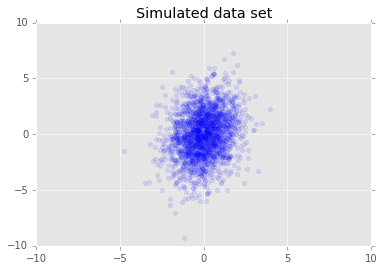

In [5]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

## Model

Consider a data set $\mathbf{X} = \{\mathbf{x}_n\}$ of $N$ data
points, where each data point is $D$-dimensional, $\mathbf{x}_n \in
\mathbb{R}^D$. We aim to represent each $\mathbf{x}_n$ under a latent
variable $\mathbf{z}_n \in \mathbb{R}^K$ with lower dimension, $K <
D$. The set of principal axes $\mathbf{W}$ relates the latent variables to
the data.

Specifically, we assume that each latent variable is normally distributed,

\begin{equation*}
\mathbf{z}_n \sim N(\mathbf{0}, \mathbf{I}).
\end{equation*}

The corresponding data point is generated via a projection,

\begin{equation*}
\mathbf{x}_n \mid \mathbf{z}_n
\sim N(\mathbf{W}\mathbf{z}_n, \sigma^2\mathbf{I}),
\end{equation*}

where the matrix $\mathbf{W}\in\mathbb{R}^{D\times K}$ are known as
the principal axes. In probabilistic PCA, we are typically interested in
estimating the principal axes $\mathbf{W}$ and the noise term
$\sigma^2$.

Probabilistic PCA generalizes classical PCA. Marginalizing out the the
latent variable, the distribution of each data point is

\begin{equation*}
\mathbf{x}_n \sim N(\mathbf{0}, \mathbf{W}\mathbf{W}^Y + \sigma^2\mathbf{I}).
\end{equation*}

Classical PCA is the specific case of probabilistic PCA when the
covariance of the noise becomes infinitesimally small, $\sigma^2 \to 0$.

We set up our model below. In our analysis, we fix $\sigma=2.0$, and
instead of point estimating $\mathbf{W}$ as a model parameter, we
place a prior over it in order to infer a distribution over principal
axes.

## Inference

The posterior distribution over the principal axes $\mathbf{W}$ cannot
be analytically determined. Below, we set up our inference variables
and then run a chosen algorithm to infer $\mathbf{W}$. Below we use
variational inference to minimize the $\text{KL}(q\|p)$ divergence
measure.

In [6]:
def nellie(s, x_train, x_test):
    D, N = x_train.shape
    _, N_test = x_test.shape
    w = Normal(mu=tf.zeros([D, K]), sigma=tf.ones([D, K]))
    z = Normal(mu=tf.zeros([N, K]), sigma=tf.ones([N, K]))
    x = Normal(mu=tf.matmul(w, z, transpose_b=True), sigma=s*tf.ones([D, N]))
    qw = Normal(mu=tf.Variable(tf.random_normal([D, K])),
                sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
    qz = Normal(mu=tf.Variable(tf.random_normal([N, K])),
                sigma=tf.nn.softplus(tf.Variable(tf.random_normal([N, K]))))

    inference = ed.KLqp({w: qw, z: qz}, data={x: x_train})
    inference.run(n_iter=1000, n_print=1000, n_samples=20)
    
    # TEST
    # create local posterior factors for test data, assuming test data
    # has N_test many data points
    print("Testing model with standard deviation %d"%(s))
    z_test = Normal(mu=tf.zeros([N_test, K]), sigma=tf.ones([N_test, K]))
    x_test_ = Normal(mu=tf.matmul(w, z_test, transpose_b=True), sigma=s*tf.ones([D, N_test]))
    qz_test = Normal(mu=tf.Variable(tf.random_normal([N_test, K])),
                sigma=tf.nn.softplus(tf.Variable(tf.random_normal([N_test, K]))))
    
    # run local inference conditional on global factors
    inference = ed.KLqp({z_test: qz_test}, data={x_test_: x_test, w: qw})
    inference.run(n_iter=1000, n_print=1000, n_samples=20)
    
    x_post = ed.copy(x_test_, {w: qw, z: qz_test})
    # build posterior predictive on test data
    return -ed.evaluate('log_likelihood', data={x_post: tf.cast(x_test,tf.float32)})

In [7]:
print(nellie(2, x_train, x_test))

Iteration    1 [  0%]: Loss = 11153.511
Iteration 1000 [100%]: Loss = 7809.715
Testing model with standard deviation 2
Iteration    1 [  0%]: Loss = 134950.562
Iteration 1000 [100%]: Loss = 77759.359
2.8766


In [8]:
def one_hprmtr2testNLL(s):
    # optimize in log-space
    s = np.exp(s)
    return nellie(s, x_train, x_test)

In [9]:
bounds = [(-2,2)]
print("So s is searched for in [log(%d), log(%d)] = [%f,%f]"%(bounds[0][0],bounds[0][1],np.exp(bounds[0][0]),np.exp(bounds[0][1])))

So s is searched for in [log(-2), log(2)] = [0.135335,7.389056]


In [10]:
# choice of model and acquisition type motivated by Practical Bayesian Optimization (Snoek et al.)
myBopt = BayesianOptimization(f=one_hprmtr2testNLL, bounds=bounds, model_type='GP_MCMC',acquisition_type='EI_MCMC',num_cores=-1)
myBopt.run_optimization(max_iter=10)

Iteration    1 [  0%]: Loss = 15668.240
Iteration 1000 [100%]: Loss = 7232.512
Testing model with standard deviation 1
Iteration    1 [  0%]: Loss = 127902.711
Iteration 1000 [100%]: Loss = 75589.141
Iteration    1 [  0%]: Loss = 788395.312
Iteration 1000 [100%]: Loss = 55978.445
Testing model with standard deviation 0
Iteration    1 [  0%]: Loss = 6561063.500
Iteration 1000 [100%]: Loss = 2197266.250
Iteration    1 [  0%]: Loss = 11853.103
Iteration 1000 [100%]: Loss = 9434.607
Testing model with standard deviation 3
Iteration    1 [  0%]: Loss = 102699.758
Iteration 1000 [100%]: Loss = 85732.680
Iteration    1 [  0%]: Loss = 12580.480
Iteration 1000 [100%]: Loss = 10615.927
Testing model with standard deviation 5
Iteration    1 [  0%]: Loss = 115538.078
Iteration 1000 [100%]: Loss = 97070.398
Iteration    1 [  0%]: Loss = 10891.011
Iteration 1000 [100%]: Loss = 7459.041
Testing model with standard deviation 1
Iteration    1 [  0%]: Loss = 124023.898
Iteration 1000 [100%]: Loss = 7973

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Iteration    1 [  0%]: Loss = 13726.875
Iteration 1000 [100%]: Loss = 11778.870
Testing model with standard deviation 7
Iteration    1 [  0%]: Loss = 123778.055
Iteration 1000 [100%]: Loss = 106620.289
Iteration    1 [  0%]: Loss = 10709.605
Iteration 1000 [100%]: Loss = 8715.082
Testing model with standard deviation 3
Iteration    1 [  0%]: Loss = 103598.172
Iteration 1000 [100%]: Loss = 81664.242
Iteration    1 [  0%]: Loss = 11006.457
Iteration 1000 [100%]: Loss = 7960.804
Testing model with standard deviation 2
Iteration    1 [  0%]: Loss = 102646.883
Iteration 1000 [100%]: Loss = 80439.617
Iteration    1 [  0%]: Loss = 10868.724
Iteration 1000 [100%]: Loss = 7579.623
Testing model with standard deviation 1
Iteration    1 [  0%]: Loss = 92998.586
Iteration 1000 [100%]: Loss = 70433.812
Iteration    1 [  0%]: Loss = 10649.250
Iteration 1000 [100%]: Loss = 7464.501
Testing model with standard deviation 1
Iteration    1 [  0%]: Loss = 108439.102
Iteration 1000 [100%]: Loss = 78271.594

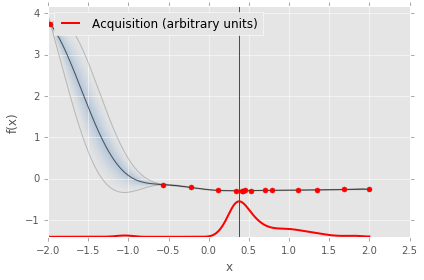

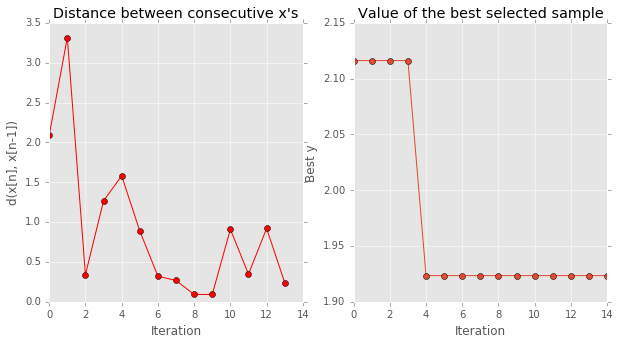

In [11]:
myBopt.plot_acquisition()
myBopt.plot_convergence()

In [12]:
%matplotlib inline

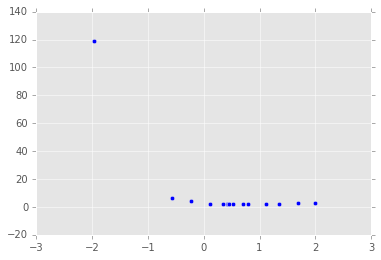

In [13]:
plt.scatter(*np.array(myBopt.get_evaluations())[:,:])

In [14]:
def one_hprmtr2testNLL2(s):
    # optimize in log-space
    return nellie(s, x_train, x_test)

In [15]:
s_opt1 = np.exp(myBopt.get_evaluations()[0][np.argmin(myBopt.get_evaluations()[1])])

In [16]:
s_opt1

array([ 1.52277634])

In [17]:
bounds = [(s_opt1*0.5,s_opt1*1.5)]

In [18]:
bounds

[(array([ 0.76138817]), array([ 2.28416451]))]

In [19]:
# choice of model and acquisition type motivated by Practical Bayesian Optimization (Snoek et al.)
myBopt2 = BayesianOptimization(f=one_hprmtr2testNLL, bounds=bounds, model_type='GP_MCMC',acquisition_type='EI_MCMC',num_cores=-1)
myBopt2.run_optimization(max_iter=5)

Iteration    1 [  0%]: Loss = 14093.346
Iteration 1000 [100%]: Loss = 12048.110
Testing model with standard deviation 7
Iteration    1 [  0%]: Loss = 125245.062
Iteration 1000 [100%]: Loss = 108744.156
Iteration    1 [  0%]: Loss = 11355.414
Iteration 1000 [100%]: Loss = 8582.917
Testing model with standard deviation 2
Iteration    1 [  0%]: Loss = 95356.617
Iteration 1000 [100%]: Loss = 78163.492
Iteration    1 [  0%]: Loss = 14239.368
Iteration 1000 [100%]: Loss = 12343.501
Testing model with standard deviation 8
Iteration    1 [  0%]: Loss = 128633.500
Iteration 1000 [100%]: Loss = 111749.156
Iteration    1 [  0%]: Loss = 12394.138
Iteration 1000 [100%]: Loss = 10426.069
Testing model with standard deviation 5
Iteration    1 [  0%]: Loss = 111114.375
Iteration 1000 [100%]: Loss = 94275.875
Iteration    1 [  0%]: Loss = 10670.371
Iteration 1000 [100%]: Loss = 8721.722
Testing model with standard deviation 3
Iteration    1 [  0%]: Loss = 99225.141
Iteration 1000 [100%]: Loss = 79604.6

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Iteration    1 [  0%]: Loss = 11077.471
Iteration 1000 [100%]: Loss = 7913.101
Testing model with standard deviation 2
Iteration    1 [  0%]: Loss = 99498.828
Iteration 1000 [100%]: Loss = 74385.188
Iteration    1 [  0%]: Loss = 12316.808
Iteration 1000 [100%]: Loss = 7913.401
Testing model with standard deviation 2
Iteration    1 [  0%]: Loss = 98275.484
Iteration 1000 [100%]: Loss = 73630.289


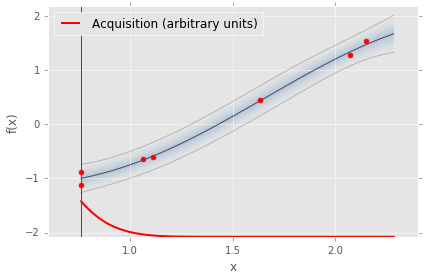

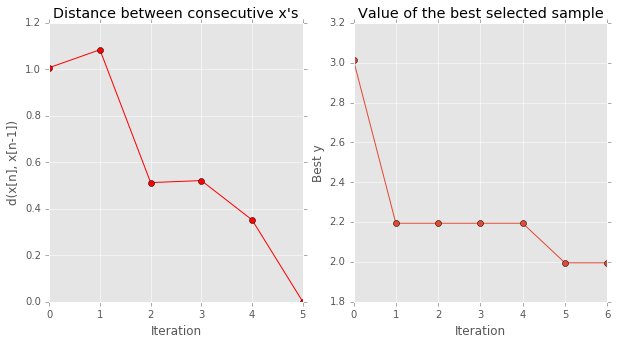

In [20]:
myBopt2.plot_acquisition()
myBopt2.plot_convergence()

In [21]:
s_opt2 = np.min(myBopt2.get_evaluations()[1])

In [22]:
print(np.array([nellie(2, x_train, x_test) for i in range(3)]).mean())

Iteration    1 [  0%]: Loss = 10731.486
Iteration 1000 [100%]: Loss = 7809.173
Testing model with standard deviation 2
Iteration    1 [  0%]: Loss = 95539.945
Iteration 1000 [100%]: Loss = 73877.445
Iteration    1 [  0%]: Loss = 12468.994
Iteration 1000 [100%]: Loss = 7809.739
Testing model with standard deviation 2
Iteration    1 [  0%]: Loss = 105055.305
Iteration 1000 [100%]: Loss = 77517.961
Iteration    1 [  0%]: Loss = 10932.487
Iteration 1000 [100%]: Loss = 7808.331
Testing model with standard deviation 2
Iteration    1 [  0%]: Loss = 99737.711
Iteration 1000 [100%]: Loss = 73706.617
2.00461


In [33]:
print(np.array([nellie(s_opt2, x_train, x_test) for i in range(3)]).mean())

Iteration    1 [  0%]: Loss = 11915.721
Iteration 1000 [100%]: Loss = 7807.283
Testing model with standard deviation 1
Iteration    1 [  0%]: Loss = 88143.617
Iteration 1000 [100%]: Loss = 70183.938
Iteration    1 [  0%]: Loss = 13826.107
Iteration 1000 [100%]: Loss = 7806.430
Testing model with standard deviation 1
Iteration    1 [  0%]: Loss = 128370.266
Iteration 1000 [100%]: Loss = 81034.875
Iteration    1 [  0%]: Loss = 11741.970
Iteration 1000 [100%]: Loss = 7805.453
Testing model with standard deviation 1
Iteration    1 [  0%]: Loss = 126079.797
Iteration 1000 [100%]: Loss = 80344.891
2.59663


In [24]:
s_opt2

1.9956760406494141

In [25]:
def ellie(s = s_opt2, x_train = X):
    D, N = x_train.shape
    _, N_test = x_test.shape
    w = Normal(mu=tf.zeros([D, K]), sigma=tf.ones([D, K]))
    z = Normal(mu=tf.zeros([N, K]), sigma=tf.ones([N, K]))
    x = Normal(mu=tf.matmul(w, z, transpose_b=True), sigma=s*tf.ones([D, N]))
    qw = Normal(mu=tf.Variable(tf.random_normal([D, K])),
                sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
    qz = Normal(mu=tf.Variable(tf.random_normal([N, K])),
                sigma=tf.nn.softplus(tf.Variable(tf.random_normal([N, K]))))

    inference = ed.KLqp({w: qw, z: qz}, data={x: x_train})
    inference.run(n_iter=500, n_print=100, n_samples=10)
    
    x_post = ed.copy(x, {w: qw, z: qz})
    return x_post, qw, qz

In [26]:
x_post, qw, qz = ellie()

Iteration   1 [  0%]: Loss = 108791.617
Iteration 100 [ 20%]: Loss = 77761.148
Iteration 200 [ 40%]: Loss = 77731.023
Iteration 300 [ 60%]: Loss = 77709.742
Iteration 400 [ 80%]: Loss = 77702.445
Iteration 500 [100%]: Loss = 77719.422


In [27]:
x_post, qw, qz = ellie(s = 2)

Iteration   1 [  0%]: Loss = 117815.945
Iteration 100 [ 20%]: Loss = 77795.258
Iteration 200 [ 40%]: Loss = 77761.188
Iteration 300 [ 60%]: Loss = 77732.047
Iteration 400 [ 80%]: Loss = 77760.344
Iteration 500 [100%]: Loss = 77746.703


## Criticism

To check our inferences, we first inspect the model's learned
principal axes.

In [28]:
sess = ed.get_session()
print("Inferred principal axes:")
qwm = sess.run(qw.mean())

Inferred principal axes:


In [29]:
qwm

array([[-0.07984132],
       [-0.52775431]], dtype=float32)

In [30]:
w_true = np.array([[ 0.25947927],[ 1.80472372]])

In [31]:
np.corrcoef(qwm.T, w_true.T)

array([[ 1., -1.],
       [-1.,  1.]])

The model has recovered the true principal axes up to finite data and
also up to identifiability (there's a symmetry in the
parameterization).

Another way to criticize the model is to visualize the observed data
against data generated from our fitted model. The blue dots represent
the original data, while the red is the inferred.

In [32]:
# Build and then generate data from the posterior predictive distribution.
x_post = ed.copy(x, {w: qw, z: qz})
x_gen = sess.run(x_post.sample())

plt.scatter(x_gen[0, :], x_gen[1, :], color='red', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Data generated from model")
plt.show()

NameError: name 'x' is not defined

The generated data looks close to the true data.

## Acknowledgements

We thank Mayank Agrawal for writing the initial version of this
tutorial.